In [ ]:
# Environment specified in environment.yml (environment name map_matching_particle_filter)
# conda env create --prefix ./envs -f environment.yml

In [25]:
import pandas as pd
import numpy as np
import os, sys
import glob, re, time

import shapely
from shapely.strtree import STRtree
from shapely.geometry import shape, Point, LineString, MultiLineString
from shapely.ops import nearest_points
import folium
import fiona
import pyproj
from functools import partial

from collections import Counter

from sklearn.metrics.pairwise import haversine_distances  # Assumes (lat, long) in radians; version 0.22.1

In [2]:
os.getcwd()

'/Volumes/LaCie/Documents/repos/particle_filter'

In [ ]:
"""
Applications of particle filters: 
1. Car positioning by map matching, as in http://www.diva-portal.org/smash/get/diva2:316556/FULLTEXT01.pdf
    Essentially same approach is described in Davidson, Collin, and Takala (2011). Application of particle filters to map-matching algorithm
    Idea also similar to Newson and Krumm (2009), though HMM is used there.
    More recent resource: Murphy, Pao, Yuen (2019). Lyft; Map matching when the map is wrong: Efficient on/off road vehicle tracking and map learning

Ideas
Rao-Blackwellization (use Kalman filter for the linear part of the dynamics model)

Initial Approach:
Use Newson and Krumm, but modify it to use particle filters instead of HMM.

So, for a given route, proceed sequentially over obs, maintaining dist of probable road segments

Assumptions (N&K):
-remove obs that are not 2*meas dist sigma from previous obs  (eliminate 39% of data in N&K)
-ignore roads 200m from obs
-zeroize very unlikely particles
"""

In [105]:
data.head()

lat       long  occupancy                time  lat_prev  long_prev
0  37.75134 -122.39488          0 2008-06-10 07:58:07       NaN        NaN
1  37.75136 -122.39527          0 2008-06-10 07:57:39  37.75134 -122.39488
2  37.75199 -122.39460          0 2008-06-10 07:55:40  37.75136 -122.39527
3  37.75080 -122.39346          0 2008-06-10 07:54:49  37.75199 -122.39460
4  37.75015 -122.39256          0 2008-06-10 07:50:37  37.75080 -122.39346

In [106]:
df = data[["lat", "long", "lat_prev", "long_prev"]].values

In [108]:
df[:5,:]

array([[  37.75134, -122.39488,        nan,        nan],
       [  37.75136, -122.39527,   37.75134, -122.39488],
       [  37.75199, -122.3946 ,   37.75136, -122.39527],
       [  37.7508 , -122.39346,   37.75199, -122.3946 ],
       [  37.75015, -122.39256,   37.7508 , -122.39346]])

In [110]:
df[:,3][:5]

array([       nan, -122.39488, -122.39527, -122.3946 , -122.39346])

In [11]:
def great_circle_dist(df):
    """
    USED BELOW IN PREPROCESSING
    df numpy array [lat, long, lat_prev, long_prev] in degrees
    
    Returns great-circle distance between point (lat,long) columns and (lat_prev, long_prev) columns, 
    in meters.
    
    Modified from https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    # convert decimal degrees to radians 
    df = df.copy()
    df = np.deg2rad(df)

    # haversine formula 
    dlon = df[:, 3] - df[:, 1] # lon2 - lon1 
    dlat = df[:, 2] - df[:, 0] # lat2 - lat1 
    a = np.add(np.square(np.sin(dlat / 2)),
               np.multiply(np.cos(df[:, 0]), 
                           np.multiply(np.cos(df[:, 2]), np.square(np.sin(dlon / 2)))
                          )
              )
    # a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = np.arcsin(np.sqrt(a)) * 2
    # c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return r * c * 1000

In [ ]:
class gps_transition_model:
    """
    Transition model to predict probability of next state given current state; simulate next state.
    GPS trace map matching use case. 
    
    N&K use as a proxy an exponential function of the difference in the great-circle distance 
    between previous observations and previous road points (similar route distance).
    Road points use map/ground-truth data. 
    -Ignore roads 200m from obs
    -If a calculated route would require the vehicle to exceed a speed of 50 m/s (112 miles per hour), zeroize
    
    !!! TODO: Get driving distance from route planner??? Results anticipated to significantly suffer otherwise. !!! 
    
    Other ideas: using dead reckoning.
    """
    def __init__(self, beta=3.0
#                  , prob_floor=0.05
                 , normalize=True
                ):
        """
        beta, float, parametrizes transition probability function
        prob_floor, float between 0 and 1, is probability below which road choices are given zero probability
        
        # beta = 3 in mapzen, https://www.mapzen.com/blog/data-driven-map-matching/
        """
        self.beta = beta
#         self.prob_floor = min(max(prob_floor, 0), 1)
        self.normalize = normalize
    
    def estimate_beta(self, data):
        """
        NOT USED
        
        Using rescaled median absolute deviation (MAD). 
        Ideally using ground truth data (none here).
        """ 
        self.beta = 3.0  # None
        
    def prob_transition(self, state_last2, obs_last2, dist_obs_m_prev, time_delta_sec_prev, 
                        max_allowable_diff_m=2000.0, max_allowable_mph=112.0):
        """
        state_last2, float numpy array, (k x 4 lat, long, lat_prev, long_prev), k candidate roads
        obs_last2, float numpy array, (1 x 4 lat, long, lat_prev, long_prev) 
        dist_obs_m_prev float distance in meters between last two obs.
        time_delta_sec_prev float time delta in sec between last two obs.
        max_allowable_diff_m float, ignore low probability routes as in N&K; in N&K 2000 meters.
        max_allowable_mph, float; ignore routes resulting in unreasonable speeds. 112mph in N&K.
        Where present, lat/long in degrees.
        
        returns probs of transition, (k x 1)
        """
        RADIUS_OF_EARTH_M = 6371000
        MILES_PER_METER = 0.000621371
        HOURS_PER_SECOND = 3600.0
        state_last2 = np.deg2rad(state_last2)
        obs_last2 = np.deg2rad(obs_last2)
        # dist_obs = abs(haversine_distances(obs_last2[:, :2], obs_last2[0, 2:]))  # (1, 1)
        # !! TODO - Supposed to be driving distance, not haversine. N&K use a route planner. Can I use shapely???
            # Probably fine as generally GPS measurements are taken close together in time- 
            # Otherwise would have to snap to roads using Shapely and get the distance between the two points. 
            # How does using driving distance even compare to haversine for obs? Isn't it better to compare apples to apples?
        dist_road = np.abs(haversine_distances(state_last2[:, :2], state_last2[:, 2:]))  # (k, 1)
        diff_dist = np.abs(np.subtract(dist_road, dist_obs_m_prev))  # (k, 1)
        diff_dist = diff_dist * RADIUS_OF_EARTH_M  # multiply by Earth radius to get result in meters
        
        # Ignore cases where diff_dist >= max_allowable_diff_m
        diff_dist[diff_dist >= max_allowable_diff_m] = np.float("inf")  # zero out these transition probs
        # Ignore cases where implied speed of route is >= max_allowable_mph; calculate speed in candidate routes
        implied_speed_road = (dist_road * RADIUS_OF_EARTH_M * MILES_PER_METER).divide(
            time_delta_sec_prev * HOURS_PER_SECOND)  # (k, 1), meters
        diff_dist[implied_speed_road >= max_allowable_mph] = np.float("inf")  # zero out these transition probs
        
        probs = np.exp(-diff_dist / self.beta) * (1 / self.beta)
        # Normalize result?
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs

In [145]:
np.exp(np.float("inf"))

0.0

In [ ]:
class gps_sensor_model:
    """
    Sensor model to predict likelihood of an obs given a particle.
    GPS trace map matching use case. 
    
    I don't have ground truth, so can't use ML easily, but
    N&K use as a proxy a normal distribution of great-circle distance between observation and road, with sigma 
    estimated from the data.
    Road points use map data. 
    -Zerioze low probability particles (diff in route distance of 2000 m. or more). 
    
    Other ideas: semi-supervised learning. 
    
    Thoughts: need efficient representation for road network that returns connecting roads/nodes for a given node
    Want to represent it as a graph/network. 
    """
    def __init__(self, sigma=4.07, normalize=True):
        self.sigma = sigma
        self.normalize = normalize
    
    def estimate_sigma(self, data):
        """
        NOT USED 
        
        Using Gather and Schultze, median-based. 
        Ideally using ground truth data (none here).
        
        I guess I could manually match some trips, then use that??
        """ 
        self.sigma = 4.07 # meters; I have no ground truth so using N&K's empirical estimate
#         self.sigma = None # median absolute deviation (MAD) formula adjusted 
    
    def estimate_likelihood(self, states, obs):
        """
        return probability of seeing that obs given potential road state hypotheses, (k x 1)
        
        states Particles numpy array representing road position hypotheses, (k x 2 lat long).
        obs (1 x 2 lat long)
        """
        RADIUS_OF_EARTH_M = 6371000
        dist_obs_roads = np.abs(haversine_distances(states, obs))  # (k x 1)
        dist_obs_roads = dist_obs_roads * RADIUS_OF_EARTH_M  # multiply by Earth radius to get result in meters
        
        probs = \
        np.exp(np.power(dist_obs_roads / self.sigma, 2) * (-0.5)) * \
        (1 / (math.sqrt(2 * math.pi) * self.sigma))
        
        # Normalize result?
        if self.normalize:
            probs = probs / np.sum(probs)
        return probs

In [2]:
class particle_filter:
    """
    Fit a particle filter to data given a transition and sensor model. 
    
    n, integer, number of particles to maintain at each step in time.
    max_road_dist_m, float, max road distance above which candidate roads aren't considered (meters). 
    prob_floor, float between 0 and 1, min probability below which candidate roads aren't considered.
    Sensor model, , is some model object we will use to predict the likelihood.
    Transition model, , is some model object we will use to predict next state.
    ## max_iter, integer, the maximum iterations used in fitting the particle filter.
    ## conv_tol, the convergence tolerance that will trigger early termination of fitting the particle filter. 
    """
    def __init__(self, n=50, max_road_dist_m=200, prob_floor=0.01, 
                 sensor_model=None, transition_model=None, 
                 viterbi_trellis=[], viterbi_trellis_idx=[]):
        self.n = n
        self.max_road_dist_m = max_road_dist_m
        self.prob_floor = min(max(prob_floor, 0), 1)
        self.particles = np.array([])
        self.weights = np.ones((1, self.n))
        
        self.sensor_model = sensor_model
        self.transition_model = transition_model
        self.viterbi_trellis = viterbi_trellis
        self.viterbi_trellis_idx = viterbi_trellis_idx
        
        self.obs = []  # Record history of observations (lat, long)
        
    def get_candidate_roads(self, obs, max_dist=200):
        """
        obs list of floats [lat, long]
        max_dist maximum allowable closest distance for prospective matched roads; those whose 
        closest point is >= max_dist meters away are ignored (200 in N&K).
        
        Leverages shapely and shapefiles for cabspotting data.
        """
        # object.distance(other)  # min distance
        # str tree
        
        return candidate_roads
    
    def estimate_weights_per_particle(self, sampled_states, obs):
        """
        Estimate likelihood of particle given evidence, P(evidence|particle).
        Uses sensor model.
        
        Obs is single observation at time t, numpy array. 
        """
        probs = self.sensor_model.estimate_likelihood(sampled_states, obs)
        return probs
        
    def apply_transition_model(self, candidate_roads, dist_prev, time_delta_prev):
        """
        returns probabilities of transition, given current particles
        numpy array of floats between 0 and 1, normalized, (n * c, 1)
        
        candidate_roads numpy array float of lat,long closest point to road from obs (N&K)
        dist_prev float, meters
        time_delta_prev float, sec
        
        Zeroize very small probability candidates, but don't change shape of particles.
        Then, if some particles are very unlikely, we cull them and resample from more likely particles. 
        """
        # Crossproduct for each particle, all roads
        state_last2 = np.concatenate([np.concatenate((self.particles, 
                                                      np.tile(c, (self.n, 1))), 
                                                     axis=1) 
                                      for c in candidate_roads], axis=0)  # (n * c, 4)
        obs_last2 = np.array(self.obs[-2:]).reshape((1, 4))
        probs = self.transition_model.prob_transition(state_last2, obs_last2, 
                                                      dist_prev, time_delta_prev)  # (n * c, 1)
        # Effectively, candidate roads will be possible from different original particle hypotheses
        # Zeroise small probs, without changing array shape
        probs[probs <= self.prob_floor] = 0.0
        # Re-normalize
        probs = probs / np.sum(probs)
        return probs
        
    def update_dist(self, obs, num_iter):
        """
        Re-sample particles from transition model given re-estimated likelihood of existing particles.
        Weighted sample with replacement. 
        
        obs list of floats [lat, long, dist_from_prev_m, time_delta_sec_prev]
        
        Note: if find no solutions, need to remove points in a signal break until HMM 'heals.'
        If break > 180 sec, separate into two trips.
        """
        # Update stored obs
        obs_coords = obs[:2]
        dist_prev, time_delta_prev = obs[2:]
        self.obs.append(obs_coords)
        # Get candidate roads given obs
        candidate_roads = self.get_candidate_roads(obs_coords) # ignore distance
        # Get transition probs; for first observation, ignore this part of the algorithm 
        # and treat sensor probs as prior probabilities (N&K.
        if num_iter > 1:
            trans_probs = self.apply_transition_model(candidate_roads, 
                                                      dist_prev, 
                                                      time_delta_prev) # (n * c, 1) first n rows for first candidate, etc.
            # Aggregate probs by candidate roads
            trans_probs_split = np.split(trans_probs, self.n, axis=0)  # (c, n)
            trans_probs_agg = np.sum(trans_probs_split, axis=1)  # (c, 1)
            # Sample new states
            sampled_states_idx = np.random.choice(range(len(candidate_roads)), 
                                                  self.n, 
                                                  trans_probs_agg)  # (1, n)
            sampled_states = candidate_roads[sampled_states_idx]  # (n, 2)
        else:
            sampled_states = candidate_roads
        
        # Get sensor probs
        sensor_probs = self.estimate_weights_per_particle(sampled_states, obs_coords)  # (n, 1)
        
        # Joint prob, for viterbi backtracking. 
        if num_iter > 1:
            joint_prob = np.multiply(
                np.multiply(sensor_probs, np.max(trans_probs_split, axis=1)[sampled_states_idx]),  # (n, 1)
                self.weights
                )
        else:
            joint_prob = sensor_probs
        self.weights = joint_prob  # Effectively setting prior probabilites in iter 1
        
        # Sample new particles
        new_particles_idx = np.random.choice(range(sampled_states.shape[0]), 
                                             self.n, 
                                             sensor_probs)  # (1, n)
        new_particles = sampled_states[new_particles_idx]  # (n, 2)
        
        # Best prior state/particle for a given candidate state, for viterbi backtracking. 
        if num_iter > 1:
            best_prior_state_idx = np.argmax(trans_probs_split, axis=1)[sampled_states_idx[new_particles_idx]]  # (1, n)
            best_prior_state = self.particles[best_prior_state_idx]  # (n, 2)
            self.viterbi_trellis.append(best_prior_state)
            self.viterbi_trellis_idx.append(best_prior_state_idx)
        
        self.particles = new_particles
        
        # Estimate current particle filter fit quality of hypotheses to data; should research good metrics more.
            # Came up with this on my own. 
        fit_quality = [np.max(self.weights), np.mean(self.weights), np.median(self.weights)]
        
        return fit_quality
        
    def fit(self, data#, max_iter=100, conv_tol=0.001
           ):
        """
        Iterate over rows in data, training particle filter. 
        Rows assumed to be sequentially ordered. 
        
        data, numpy array (num obs, data dim)
        data cols include exactly lat, long, lat_prev, long_prev, dist_from_prev_m, time_delta_sec_prev (all floats)
        """
        num_iter = 0
        converged = False  # Is this relevant for particle filters?
#         while num_iter < max_iter and not converged:
#             num_iter += 1
        for obs in data:
            num_iter += 1
            fit_quality = self.update_dist(obs, num_iter)
            # Shouldn't I use DP/Viterbi for this?? 
            # Nearest neighbor filter, hungarian algorithm?? p. 601
            # Best at any given point in time will suffer in the beginning before particle dist has converged, ie
            # during the burn-in period.
            # So, seems can still use DP, but proceed backward in time. Wait, that is Viterbi :) 
                # Happily I have a finite state space. 
            print("On iteration %d, fit quality of MAX %3.2f, MEAN %3.2f, MEDIAN %3.2f" % 
                  (num_iter, fit_quality[0], fit_quality[1], fit_quality[2]))
        print("Done.")
        return fit_quality
    
    def viterbi(self, y_vector_arr):
        """
        Returns list of backtracked states (float lat long),
        the imputed GPS trace that has been 'snapped' to roads.
        Use Viterbi to get optimal path via DP - 
        happily I have a finite state space due to my constraint 
        to only maintain n particles. 
        
        Note, Viterbi relies on the Markov property, which
        can apply here. 
        """
        # Start with the last observation to the viterbi trellis
        best_last_state_idx = np.argmax(self.weights)
        best_last_state = self.particles[best_last_state_idx]
        backtracked_states = [best_last_state]
        # Backtrack through the viterbi trellis (#obs, n, 2) actual lat/long states
        for j in range(len(self.viterbi_trellis) - 1, -1, -1):
            best_last_state_idx = self.viterbi_trellis_idx[j][best_last_state_idx]
            best_last_state = self.viterbi_trellis[j][best_last_state_idx]
            backtracked_states.append(best_last_state)
        # Put in chronological order
        backtracked_states = backtracked_states[::-1]
        return backtracked_states

'0.24.2'

In [4]:
## it seems i only have beijing data (10K) or sf taxi data (500)
# Read in taxi data
# Each data of different length; ideal use case for pyspark
# Note, the OSM extract basemap data has POI info as well (https://download.bbbike.org)
# also try uber h3 spatial index
trace_dir = '/Volumes/LaCie/datasets/ms_taxi/taxi_log_2008_by_id/roads.shp'   # MS Taxi
basemap_dir = '/Volumes/LaCie/datasets/Beijing-shp/shape/'

trace_dir = '/Volumes/LaCie/datasets/cabspottingdata/'   # CRAWDAD cabspotting
basemap_dir = '/Volumes/LaCie/datasets/SanFrancisco-shp/shape/roads.shp'

In [5]:
%%time
all_files = [f for f in os.listdir(trace_dir) if re.match(r'new_.*\.txt', f)]  # glob.glob(trace_dir + "new_*.txt")

CPU times: user 2.26 ms, sys: 4.34 ms, total: 6.61 ms
Wall time: 56.6 ms


In [6]:
%%time
# 20.9s cabspottingdata; can try spark or dask? or multiprocessing, joblib
trace_list = []
for file_ in all_files:
    file_df = pd.read_csv(os.path.join(trace_dir, file_), sep=" ", index_col=None, header=None, 
                          names=['lat', 'long', 'occupancy', 'time'])
    trace_list.append(file_df)

# concatenate all dfs into one
trace_df = pd.concat(trace_list, ignore_index=True)

CPU times: user 7.85 s, sys: 1.96 s, total: 9.81 s
Wall time: 14.5 s


In [7]:
trace_df.loc[:, ["time"]] = pd.to_datetime(trace_df.time, origin="unix", unit='s')

In [8]:
"""
cabspotting:

latitude and longitude are in decimal degrees, 
occupancy shows if a cab has a fare (1 = occupied, 0 = free) and 
time is in UNIX epoch format
"""
trace_df.dtypes

lat                 float64
long                float64
occupancy             int64
time         datetime64[ns]
dtype: object

In [9]:
trace_df.head()

lat       long  occupancy                time
0  37.75134 -122.39488          0 2008-06-10 07:58:07
1  37.75136 -122.39527          0 2008-06-10 07:57:39
2  37.75199 -122.39460          0 2008-06-10 07:55:40
3  37.75080 -122.39346          0 2008-06-10 07:54:49
4  37.75015 -122.39256          0 2008-06-10 07:50:37

In [ ]:
# Load in ...shapefiles? GeoJSON? Which format is best? For parallelization may be one thing...

In [3]:
def preprocess_traces(df, sigma=4.07):
    """
    pandas df, trace_df above with float columns lat, long in degrees
    sigma float, representing std dev of measurement error (see above in particle filter class)
    
    "The justification for this step is that until we see a point that is at least 2𝜎𝑧 
    away from its temporal predecessor, our confidence is low that the apparent movement
    is due to actual vehicle movement and not noise." (N&K)
    
    -remove obs that are not 2*meas dist sigma from previous obs  (eliminate 39% of data in N&K)
    -Letting sigma = 4.07 meters as in N&K
    """
    MILES_PER_METER = 0.000621371
    HOURS_PER_SECOND = 3600.0
    data = df.copy()
    data[["lat_prev", "long_prev"]] = data[["lat", "long"]].shift(1)
    # Ignore warning about invalid value in arcsin (nan)
    data["dist_from_prev_m"] = great_circle_dist(data[["lat_prev", "long_prev", "lat", "long"]].values)  # 1.93 sec
    # Add speed so can later filter on unreasonably high speeds
    data["time_delta_sec"] = data.time.subtract(data.time.shift(1)) / np.timedelta64(1, 's')  # get seconds
    data["speed_mph"] = (data.dist_from_prev_m * MILES_PER_METER).divide(data.time_delta_sec * HOURS_PER_SECOND)
    # Take cumsum of dist
    dist_cum = data.dist_from_prev_m.cumsum()
    # Select points closest to multiples of 2*sigma, in cumsum dist
    dist_cum_idx = dist_cum // (2 * sigma)
    filter_idx = np.subtract(dist_cum_idx, dist_cum_idx.shift(1)) == 0  # 12% of rows eliminated 
    data = data[~filter_idx]
    return data

In [12]:
%%time
# 11.8 s
trace_df = preprocess_traces(trace_df)

/Volumes/LaCie/anaconda/envs/map_matching_particle_filter/lib/python3.7/site-packages/ipykernel/__main__.py:24: RuntimeWarning: invalid value encountered in arcsin


CPU times: user 5.72 s, sys: 4.04 s, total: 9.76 s
Wall time: 8.6 s


In [112]:
trace_df.head()

lat       long  occupancy                time  lat_prev  long_prev  \
0  37.75134 -122.39488          0 2008-06-10 07:58:07       NaN        NaN   
1  37.75136 -122.39527          0 2008-06-10 07:57:39  37.75134 -122.39488   
2  37.75199 -122.39460          0 2008-06-10 07:55:40  37.75136 -122.39527   
3  37.75080 -122.39346          0 2008-06-10 07:54:49  37.75199 -122.39460   
4  37.75015 -122.39256          0 2008-06-10 07:50:37  37.75080 -122.39346   

   dist_from_prev_m  time_delta_sec     speed_mph  
0               NaN             NaN           NaN  
1         34.360479           -28.0 -2.118116e-07  
2         91.527346          -119.0 -1.327555e-07  
3        165.996049           -51.0 -5.617927e-07  
4        107.168918          -252.0 -7.340350e-08

In [14]:
trace_df.loc[1, ['long', 'lat']]

long   -122.395
lat     37.7514
Name: 1, dtype: object

In [15]:
# Fiona uses (long, lat) format
obs = Point(trace_df.loc[1, ['long', 'lat']])

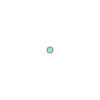

In [16]:
obs

In [17]:
%%time
roads_shp = fiona.open(basemap_dir)

CPU times: user 4.12 ms, sys: 11.7 ms, total: 15.8 ms
Wall time: 278 ms


In [18]:
roads_shp.crs

{'init': 'epsg:4326'}

In [ ]:
## https://gis.stackexchange.com/questions/80881/what-is-unit-of-shapely-length-attribute
# line1 = LineString([(15.799406, 40.636069), (15.810173,40.640246)])
# print str(line1.length) + " degrees"
# # 0.0115488362184 degrees

# # Geometry transform function based on pyproj.transform
# project_m = partial(
#     pyproj.transform,
#     pyproj.Proj(init='EPSG:4326'),
#     pyproj.Proj(init='EPSG:32633'))

# line2 = transform(project_m, line1)
# print str(line2.length) + " meters"
# # 1021.77585965 meters

In [19]:
roads_shp.schema

{'properties': OrderedDict([('osm_id', 'int:11'),
              ('name', 'str:48'),
              ('ref', 'str:16'),
              ('type', 'str:16'),
              ('oneway', 'int:1'),
              ('bridge', 'int:1'),
              ('maxspeed', 'int:3')]),
 'geometry': 'LineString'}

In [20]:
# Types of geometries
set([r['geometry']['type'] for r in list(roads_shp)])
# sf_shp: {'LineString'}

{'LineString'}

In [21]:
roads_shp[0]

{'type': 'Feature',
 'id': '0',
 'properties': OrderedDict([('osm_id', 4311275),
              ('name', 'Bayshore Freeway'),
              ('ref', 'US 101'),
              ('type', 'motorway'),
              ('oneway', 1),
              ('bridge', 0),
              ('maxspeed', 65)]),
 'geometry': {'type': 'LineString',
  'coordinates': [(-122.4067318, 37.6552091),
   (-122.4066705, 37.6554806),
   (-122.4066, 37.6557348),
   (-122.4065183, 37.6560026),
   (-122.4064254, 37.6562575),
   (-122.4063177, 37.6565034),
   (-122.4061926, 37.6567579),
   (-122.4055559, 37.6579996),
   (-122.4053176, 37.6584642),
   (-122.4051888, 37.658704),
   (-122.405056, 37.6589448),
   (-122.4049166, 37.659174),
   (-122.4047675, 37.6593902),
   (-122.4046031, 37.6596144),
   (-122.4044278, 37.6598328),
   (-122.404206, 37.660081),
   (-122.4039932, 37.6603049),
   (-122.4037717, 37.6605162),
   (-122.4035097, 37.6607433),
   (-122.4032666, 37.6609362),
   (-122.4030265, 37.6611163),
   (-122.402762, 37.

In [22]:
%%time
# Wall time: 1.79 s
# Just preserving geometries for my purpose
road_geoms = [shape(shp['geometry']) for shp in roads_shp]

CPU times: user 1.47 s, sys: 37.2 ms, total: 1.51 s
Wall time: 1.82 s


In [23]:
%%time
# Wall time: 282 ms
# Create STR-tree
road_strtree = STRtree(road_geoms)

CPU times: user 250 ms, sys: 11.3 ms, total: 261 ms
Wall time: 267 ms


In [24]:
max_dist=200

In [ ]:
# https://stackoverflow.com/questions/4102520/how-to-transform-a-distance-from-degrees-to-metres
"""
@winwaed
The transformation between degrees and metres varies across the Earth's surface.
Assuming a spherical Earth, degrees latitude = distance * 360 / (2*PI * 6400000)
Note that longitude will vary according to the latitude:
Degrees longitude = distance *360 * / (2*PI* cos(latitude) )

The above is for the Earth's surface, and does not use the Mercator projection. 
If you wish to work with projected linear distance, then you will need to use the Mercator projection.
"""
# RADIUS_OF_EARTH_M = 6371000
# long, lat = list(obs.coords)[0]
# max_dist_deg = max_dist * 360 / (2 * np.pi * RADIUS_OF_EARTH_M)

In [35]:
# Want to consider only matches within max_dist meters
    # Need to transform decimal degrees into meters
# obs.buffer(1.0)
matching_roads = road_strtree.query(obs)

In [78]:
list(obs.coords)[0]

(-122.39527, 37.75136)

In [80]:
# Ordered as (obs, road); just take road's coords
# Take only the closest point on the candidate road (1st index)
closest_pts = [[list(p.coords)[0] for p in nearest_points(obs, r)][1] for r in matching_roads]

In [81]:
# (obs, road)
closest_pts

[(-122.4279075, 37.7564972), (-122.3952268, 37.7512915)]

In [82]:
np.array(closest_pts)

array([[-122.4279075,   37.7564972],
       [-122.3952268,   37.7512915]])

In [83]:
np.tile(np.array(obs), (2, 1))

array([[-122.39527,   37.75136],
       [-122.39527,   37.75136]])

In [84]:
closest_pts = np.array(closest_pts)

In [88]:
# Calculate distance between obs and candidate_roads, to filter them
candidate_dist_coords = \
np.concatenate([closest_pts, np.tile(np.array(obs), (closest_pts.shape[0], 1))], axis=1)

In [89]:
candidate_dists = great_circle_dist(candidate_dist_coords)

In [90]:
candidate_dists

array([3642.01717592,    6.30297873])

In [93]:
# Filtered result of closest point on matching candidate roads
closest_pts[candidate_dists <= max_dist]

array([[-122.3952268,   37.7512915]])

In [113]:
data.head()

lat       long  occupancy                time  lat_prev  long_prev
0  37.75134 -122.39488          0 2008-06-10 07:58:07       NaN        NaN
1  37.75136 -122.39527          0 2008-06-10 07:57:39  37.75134 -122.39488
2  37.75199 -122.39460          0 2008-06-10 07:55:40  37.75136 -122.39527
3  37.75080 -122.39346          0 2008-06-10 07:54:49  37.75199 -122.39460
4  37.75015 -122.39256          0 2008-06-10 07:50:37  37.75080 -122.39346

In [ ]:
def get_candidate_roads(self, obs, road_strtree, road_geoms, max_dist=200):
    """
    obs list of floats [lat, long]
    max_dist maximum allowable closest distance for prospective matched roads; those whose 
    closest point is >= max_dist meters away are ignored (200 in N&K).
    Returns numpy array float of lat,long closest point to road from obs (N&K).

    Leverages shapely and shapefiles for cabspotting data.
    """
    # object.distance(other)  # min distance
    # str tree

    return candidate_roads

In [126]:
"""
dist_cabspotting = great_circle_dist(data[["lat_prev", "long_prev", "lat", "long"]].values[1:])
np.histogram(dist_cabspotting[dist_cabspotting <=750])

(array([3350723,  982551, 1150459, 1113760,  965676,  765890,  532474,
         399776,  272899,  202794]),
 array([  0.        ,  74.999973  , 149.999946  , 224.999919  ,
        299.99989201, 374.99986501, 449.99983801, 524.99981101,
        599.99978401, 674.99975701, 749.99973001]))
"""
%%time
dist_cabspotting = great_circle_dist(data[["lat_prev", "long_prev", "lat", "long"]].values[1:])

CPU times: user 1.22 s, sys: 662 ms, total: 1.88 s
Wall time: 1.95 s
